In [ ]:
pip install SQLAlchemy==1.1.5

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as sts

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, distinct

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
#check columns in measurement table
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine) 

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent = session.query(measurement.date).order_by(measurement.date.desc()).first()  
print(most_recent)


('2017-08-23',)


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
date = dt.datetime(2016, 8, 23)
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp).\
filter(measurement.date > date).all()

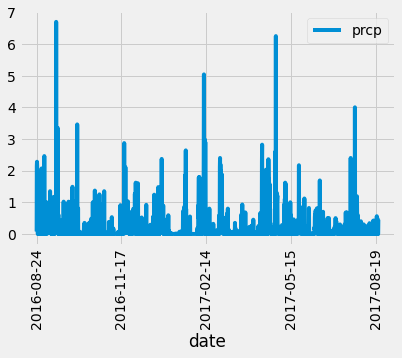

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(precipitation_data).set_index('date')
# Sort the dataframe by date
df2 = df.sort_values(by='date').dropna()
# Use Pandas Plotting with Matplotlib to plot the data
df2.plot(rot=90)

In [15]:
p = df2['prcp'].dropna()
p

date
2016-08-24    0.08
2016-08-24    2.15
2016-08-24    2.28
2016-08-24    2.15
2016-08-24    1.45
              ... 
2017-08-22    0.00
2017-08-23    0.08
2017-08-23    0.00
2017-08-23    0.00
2017-08-23    0.45
Name: prcp, Length: 2015, dtype: float64

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
mean_numpy = np.mean(p)
print(f"The mean precipitation for the year of 8-23-2016 to 8-23-2017 is {mean_numpy}")

median_numpy = np.median(p)
print(f"The median precipitation for the year of 8-23-2016 to 8-23-2017 is {median_numpy}")

mode_scipy = sts.mode(p)
print(f"The mode precipitation for the year of 8-23-2016 to 8-23-2017 is {mode_scipy}")

var_numpy = np.var(p,ddof = 0)
print(f"The precipitation variance for the year of 8-23-2016 to 8-23-2017 is {var_numpy}")

sd_numpy = np.std(p,ddof = 0)
print(f"The precipitation standard deviation using the NumPy module is {sd_numpy}") 

quartiles = p.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of precipitation is: {lowerq}")
print(f"The upper quartile of precipitation is: {upperq}")
print(f"The interquartile range of precipitation is: {iqr}")
print(f"The the median of precipitation is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The mean precipitation for the year of 8-23-2016 to 8-23-2017 is 0.17646153846153778
The median precipitation for the year of 8-23-2016 to 8-23-2017 is 0.02
The mode precipitation for the year of 8-23-2016 to 8-23-2017 is ModeResult(mode=array([0.]), count=array([873]))
The precipitation variance for the year of 8-23-2016 to 8-23-2017 is 0.21176023363236773
The precipitation standard deviation using the NumPy module is 0.4601741340322897
The lower quartile of precipitation is: 0.0
The upper quartile of precipitation is: 0.13
The interquartile range of precipitation is: 0.13
The the median of precipitation is: 0.02 
Values below -0.195 could be outliers.
Values above 0.325 could be outliers.


In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df2.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(func.count(distinct(measurement.station))).all()
total_stations


[(9)]

In [20]:
#alternate from df 
total_stations = session.query(measurement.station)
total_stations_df = pd.DataFrame(total_stations).nunique()
total_stations_df


station    9
dtype: int64

In [ ]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
'''
active_stations = session.query(func.count(measurement.station)).\
        group_by(measurement.station).\
        order_by(func.count(measurement.station.desc())).all()
active_stations
'''

# List the stations and the counts in descending order.
active_stations = session.query(measurement.id, measurement.station, measurement.date, measurement.prcp, measurement.tobs)
active_stations_df = pd.DataFrame(active_stations)
most_active_counts = active_stations_df['station'].value_counts()
most_active_counts

In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations_df.loc[most_active_df["station"] == "USC00519281"]
most_active_station

lowest_temp = most_active_station["tobs"].min()
highest_temp = most_active_station["tobs"].max()
ave_temp = most_active_station["tobs"].mean()

print(f'The lowest temperature recorded for the most active station is {lowest_temp} degrees.')
print(f'The highest temperature recorded for the most active station is {highest_temp} degrees.')
print(f'The average temperature recorded for the most active station is {ave_temp} degrees.')

In [ ]:
sel = [measurement.id, 
      func.min(measuremnt)]

In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Calculate the date one year from the last date in data set.

# Perform a query to retrieve the data and precipitation scores


# Close session

In [ ]:
# Close Session
session.close()